# DECOMON tutorial #1

_**Bounding the output of a Neural Network trained on a sinusoidal function**_

After training a model, we want to make sure that the model is *smooth*: it will predict almost the same output for any data "close" to the initial one, showing some robustness to perturbation. 

In this notebook, we train a Neural Network to approximate at best a simple sinusoidal function (the reference model). However, between test samples, we have no clue that the output of the Neural Network will look like. The objective is to have a formal proof that outputs of the neural network's predictions do not go to weird values. 

In the first part of the notebook, we define the reference function, build a training and test dataset and learn a dense fully connected neural network to approximate this reference function. 

In the second part of the notebook, we use *decomon* to compute guaranteed bounds to the output of the model.  

What we will show is how decomon module is able to provide guaranteed bounds that ensure our approximation will never have a strange behaviour between test dataset points. 

- When running this notebook on Colab, we need to install *decomon* if on Colab. 
- If you run this notebook locally, do it inside the environment in which you [installed *decomon*](https://airbus.github.io/decomon/main/install.html).

In [1]:
# On Colab: install the library
on_colab = "google.colab" in str(get_ipython())
if on_colab:
    import sys  # noqa: avoid having this import removed by pycln

    # install dev version for dev doc, or release version for release doc
    !{sys.executable} -m pip install -U pip
    !{sys.executable} -m pip install git+https://github.com/airbus/decomon@main#egg=decomon

## Imports

In [2]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras

%matplotlib inline
import ipywidgets as widgets
import numpy as np
from ipywidgets import interact
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential

print("Notebook run using keras:", keras.__version__)

2023-01-31 10:03:42.570157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Notebook run using keras: 2.11.0


## Build and Train a Neural Network on a sinusoide

The sinusoide funtion is defined on a $[-1 ; 1 ]$ interval. We put a factor in the sinusoide to have several periods of oscillations. 


In [3]:
x = np.linspace(-1, 1, 1000)
y = np.sin(10 * x)

We approximate this function by a fully connected network composed of 4 hidden layers of size 100, 100, 20 and 20 respectively. Rectified Linear Units (ReLU) are chosen as activation functions for all the neurons. 

In [4]:
layers = []
layers.append(Dense(100, activation="linear", input_dim=1))  # specify the dimension of the input space
layers.append(Activation("relu"))
layers.append(Dense(100, activation="linear"))
layers.append(Activation("relu"))
layers.append(Dense(20, activation="linear"))
layers.append(Activation("relu"))
layers.append(Dense(20, activation="linear"))
layers.append(Activation("relu"))
layers.append(Dense(1, activation="linear"))
model = Sequential(layers)

2023-01-31 10:03:45.038801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


we specify the optimization method and the metric, in this case a classical Means Square Error. 

In [5]:
model.compile("adam", "mse")

we train the neural network

In [6]:
model.fit(x, y, batch_size=32, shuffle=True, epochs=100, verbose=0)
# verbose=0 removes the printing along the training

we can now display the output of our neural network on a more refined grid. 

In [7]:
x_test = np.linspace(-1, 1, 2000)
y_pred = model.predict(x_test)

63/63 [==============================] - 0s 850us/step


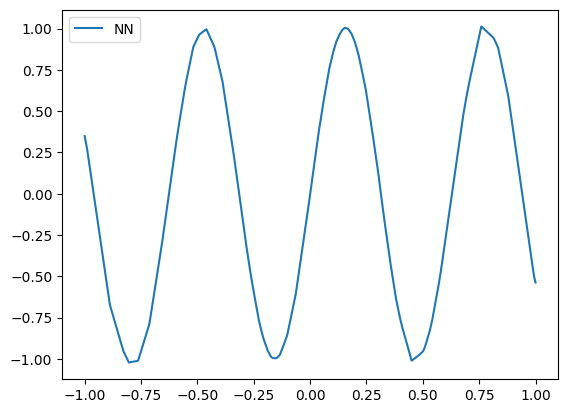

In [8]:
plt.plot(x_test, y_pred)
plt.legend(["NN"])

It looks reasonably as a sinus function and nothing crazy is happening. Still, are we able to ensure that when testing on a finer grid, there will not be a point where the learnt model will not infer a crazy output? The answer is in general no, we cannot. And this is more and more true when the complexity of the model is increasing.

Shallow networks are more likely to be part of no human intervention system. They require our full attention and our best efforts to ensure safety. Usually we tend to *trust* the prediction of neural network based solely on the prediction on the test dataset. However, with a tighter granularity or using verification methods, we would actually realize that the neural network outputs an unintended peak. We highlight this unintended behaviour in the next figure
    
   <img src="./data/sinusoide/sinusoide_fail.png" alt="sinusoide_fail" width="400"/> 

Fortunately, decomon allows to find rigorous bounds of the model that will be true on the full input domain definition. 

<img src="./data/decomon.jpg" alt="Decomon!" width="400"/>

## Applying decomon

First *decomon* requires specific imports

In [9]:
from decomon import get_lower_box, get_range_box, get_upper_box
from decomon.models import clone

Could not import GroupSort or GroupSort2 from deel.lip.activations. Please install deel-lip for being compatible with 1 Lipschitz network (see https://github.com/deel-ai/deel-lip)


Next, we can compute global constant upper and lower bounds that hold for the whole interval [-1, 1] To use decomon, we need to convert it into another Keras Model that contains extra information necessary to compute upper and lower bounds on a domain. Without setting specific options, **decomon_model** will share the parameters (a.k.a weights and biases) of our model.

Several methods exist and we refer you to [Automatic Perturbation Analysis for
Scalable Certified Robustness and Beyond](https://proceedings.neurips.cc/paper/2020/file/0cbc5671ae26f67871cb914d81ef8fc1-Paper.pdf)

In [10]:
# convert our model into a decomon model:
decomon_model = clone(model, method="crown")  # method is optionnal

Several methods are possible among this list: **ibp, forward, hybrid, crown-ibp, crown-forward, crown-hybrid, crown**.

Depending on the inner recipes, those methods will output different informations:
    <ul> **ibp**: constant upper and lower bounds that outer-approximate every output neurons</ul>
    <ul> **forward**: affine upper bound and affine lower bound given the input of the network that outer-approximate every output neurons</ul>
    <ul> **hybrid, crown, crown-(...)**: other previously cited methods will output both information</ul>
    
By default, the convert method converts the Keras model in **crown**.

1/1 [==============================] - 0s 34ms/step
0.2983329999999995


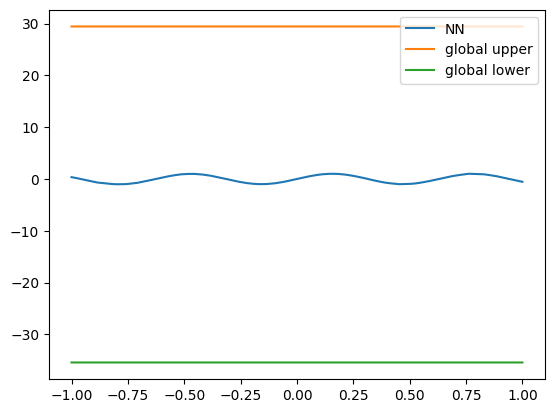

In [16]:
import time
start_time = time.process_time()
X_min = np.array([x.min()])
X_max = np.array([x.max()])

global_upper = get_upper_box(decomon_model, X_min, X_max, fast=False)
global_lower = get_lower_box(decomon_model, X_min, X_max, fast=False)
end_time = time.process_time()
print( end_time-start_time)

plt.plot(x_test, y_pred)
plt.plot(x_test, global_upper * np.ones_like(y_pred))
plt.plot(x_test, global_lower * np.ones_like(y_pred))
plt.legend(["NN", "global upper", "global lower"])

In a tighter region, the bounds became tighter



In [12]:
# you can play with the interval [x_min, x_max]
x_min = -0.25
x_max = 0.25
X_min = np.array([x_min])
X_max = np.array([x_max])

refine_upper, refine_lower = get_range_box(decomon_model, X_min, X_max)

print(
    "if {}<= x <= {}, we can ensure that {} <= NN(x) <= {}".format(x_min, x_max, refine_lower.min(), refine_upper.min())
)

1/1 [==============================] - 0s 30ms/step
if -0.25<= x <= 0.25, we can ensure that -4.0045390129089355 <= NN(x) <= 4.282904386520386


In [13]:
def func(min_value=-1.0, max_value=1.0, n_step=300):

    if min_value > max_value:
        print("Error min_value={} >max_value={}. Reset the demo to the whole domain".format(min_value, max_value))
        min_value = -1
        max_value = 1.0
    samples = np.linspace(min_value, max_value, n_step)

    boxes = np.zeros((len(samples[:-1]), 2, 1))
    boxes[:, 0, 0] = samples[:-1]
    boxes[:, 1, 0] = samples[1:]

    _, upper, _, _, lower, _, _ = decomon_model.predict(boxes)

    upper = get_upper_box(decomon_model, samples[:-1], samples[1:])
    lower = get_lower_box(decomon_model, samples[:-1], samples[1:])

    y_samples = model.predict(samples)

    x_ = []
    upper_ = []
    lower_ = []

    # lower and upper bounds are step function
    for i in range(n_step - 1):
        x_.append(samples[i])
        x_.append(samples[i + 1])
        upper_.append(upper[i])
        upper_.append(upper[i])
        lower_.append(lower[i])
        lower_.append(lower[i])

    ##########
    n_cols = 2
    fig, axs = plt.subplots(n_cols)
    fig.set_figheight(n_cols * fig.get_figheight())
    fig.set_figwidth(n_cols * fig.get_figwidth())
    plt.subplots_adjust(hspace=0.2)  # increase vertical separation
    axs_seq = axs.ravel()

    ax = axs[0]
    ax.plot(x_test, y_pred)
    ax.plot(samples, y_samples, "x", c="k")
    ax.legend(["NN"])
    ax.set_title("Sampling n_step={}".format(n_step))

    ax = axs[1]
    ax.plot(x_test, y_pred)
    ax.plot(samples, y_samples, "x", c="k")
    ax.plot(samples, y_samples)
    ax.plot(x_, upper_, c="purple")
    ax.plot(x_, lower_, c="orange")
    ax.legend(["NN", "test", "interpolation", "upper", "lower"])
    ax.set_title("Bounding the prediction of the neural network")

In [14]:
interact(
    func,
    n_step=widgets.IntSlider(value=0, min=10, max=100, step=1, continuous_update=False),
    min_value=widgets.FloatSlider(value=-0.3, min=-1, max=1.0, step=0.01, continuous_update=False),
    max_value=widgets.FloatSlider(value=0.3, min=-1, max=1, step=0.01, continuous_update=False),
)

interactive(children=(FloatSlider(value=-0.3, continuous_update=False, description='min_value', max=1.0, min=-…

<function __main__.func(min_value=-1.0, max_value=1.0, n_step=300)>

In the previous interactive graph, you can set:
- n_step: the number of intervals on which we divide the input space to improve the bounds deduced from *decomon*
- min_value: the minimun value of the interval
- max_value: the maximum value of the interval

The graphs below show you:
- the trained model with sample values drawn with the n_step discretization of the $[min_{value} ; max_{value}]$ interval
- the increasing and decreasing function on each local interval and in dashed the increasing and decreasing function computed on the whole interval
- the bounds computed with *decomon* on the n_step intervals

Increasing the number of n_step allows to have tighter bounds. Hopefully, this number will keep reasonable for your preferred model!

Enjoy!